In [1]:
%matplotlib widget
from pathlib import Path
import sys
import os
base_path = Path(os.path.abspath('')).parent
print(base_path)
sys.path.append(str(base_path))
import torch
from modules.tensor_nerf import TensorNeRF
from fields.listrf import ListRF
from samplers.nerf_acc import NerfAccSampler
from icecream import ic

import imageio

import matplotlib.pyplot as plt


def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im.copy())
    plt.close()
    display(fig.figure)

/home/dronelab/normalrf
Warp 0.6.2 initialized:
   CUDA Toolkit: 11.5, Driver: 12.0
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA GeForce RTX 3090 (sm_86)
     "cuda:1" | NVIDIA GeForce RTX 3090 (sm_86)
     "cuda:2" | NVIDIA GeForce RTX 3090 (sm_86)
     "cuda:3" | NVIDIA GeForce RTX 3090 (sm_86)
     "cuda:4" | NVIDIA GeForce RTX 3090 (sm_86)
   Kernel cache: /home/dronelab/.cache/warp/0.6.2


In [6]:


log_dir = Path("../log") / "noprednorms_nl0_conserve_pb0"
ckpt1 = log_dir / 'car_v38' / 'car_v38.th'
ckpt2 = log_dir / 'toaster_v38' / 'toaster_v38.th'

tensorf1 = TensorNeRF.load(torch.load(ckpt1), near_far=[2, 6], strict=False)
tensorf2 = TensorNeRF.load(torch.load(ckpt2), near_far=[2, 6], strict=False)
device = torch.device('cuda:1')
tensorf1 = tensorf1.cpu()
tensorf2 = tensorf2.cpu()
offsets = [
    torch.tensor([[0, 0.0, 0, 0]]),
    torch.tensor([[1.2, 0.0, 0, 0]]),
]

aabb1 = tensorf1.rf.aabb + offsets[0][:, :3]
aabb2 = tensorf2.rf.aabb + offsets[1][:, :3]
aabb = torch.stack([
    torch.minimum(aabb1[0], aabb1[0]),
    torch.maximum(aabb1[1], aabb1[1]),
], dim=0)

listrf = ListRF([tensorf1.rf, tensorf2.rf], offsets)
# tensorf2.rf = listrf
tensorf = tensorf1
tensorf.rf = listrf

tensorf.sampler = NerfAccSampler(aabb, [2, 5], grid_size=128,
         render_n_samples=1024, max_samples=-1, multiplier=1,
         test_multiplier=1, update_freq=16, shrink_iters=[],
         alpha_thres = 1e-4, ema_decay = 0.95, occ_thre=0.01,
         warmup_iters=256)#.to(device)

tensorf = tensorf1.to(device)
tensorf.sampler.update(tensorf.rf, init=True)
for i in range(1000):
    tensorf.sampler.check_schedule(i, 1, tensorf.rf)

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [3]:


from dataLoader.ray_utils import get_ray_directions, get_rays
from renderer import chunk_renderer, BundleRender
import numpy as np

w = 800
h = 800
camera_angle_x = 0.6194058656692505

fx = 0.5 * w / np.tan(0.5 * camera_angle_x)  # original focal length
fy = fx

directions = get_ray_directions(h, w, [fx,fy])  # (h, w, 3)
directions = directions / torch.norm(directions, dim=-1, keepdim=True)
c2w = torch.eye(4)
blender2opencv = torch.tensor([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]).float()

c2w = torch.tensor([
    [
        -0.9999021291732788,
        0.004192245192825794,
        -0.013345719315111637,
        -0.05379832163453102
    ],
    [
        -0.013988680206239223,
        -0.2996590733528137,
        0.95394366979599,
        3.845470428466797
    ],
    [
        -4.6566125955216364e-10,
        0.9540371894836426,
        0.29968830943107605,
        1.2080823183059692
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv
c2w = torch.tensor([
    [
        0.24868656694889069,
        -0.6090989112854004,
        0.7530957460403442,
        3.0358264446258545
    ],
    [
        0.9685839414596558,
        0.1563878208398819,
        -0.1933593899011612,
        -0.7794567346572876
    ],
    [
        -7.450580152834618e-09,
        0.7775223851203918,
        0.6288550496101379,
        2.5349960327148438
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv

c2w = torch.tensor([
    [
        -0.24868960678577423,
        0.6655282974243164,
        -0.7037226557731628,
        -2.836796998977661
    ],
    [
        -0.9685831665992737,
        -0.17087841033935547,
        0.18068504333496094,
        0.7283647656440735
    ],
    [
        0.0,
        0.7265485525131226,
        0.6871150732040405,
        2.7698497772216797
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv

c2w = torch.tensor([
    [
        0.6845461130142212,
        -0.24688588082790375,
        0.6858890652656555,
        2.7649075984954834
    ],
    [
        0.7289695143699646,
        0.23184067010879517,
        -0.644091010093689,
        -2.596414089202881
    ],
    [
        -1.4901159417490817e-08,
        0.9409023523330688,
        0.33867788314819336,
        1.365254282951355
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv




rays_o, rays_d = get_rays(directions, c2w)  # both (h*w, 3)

rays = torch.cat([rays_o, rays_d], 1).to(device)

/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
torch.cuda.empty_cache()
tensorf = tensorf1
tensorf.model.max_retrace_rays=[400000]
tensorf.model.max_brdf_rays=[500000, 500000]
tensorf.eval_batch_size=5000
tensorf.model.russian_roulette = True


brender = BundleRender(chunk_renderer, h, w, 1)
ims, stats = brender(rays, tensorf, N_samples=-1, ndc_ray=False, is_train=False)
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))

RuntimeError: roi must be a CUDA tensor

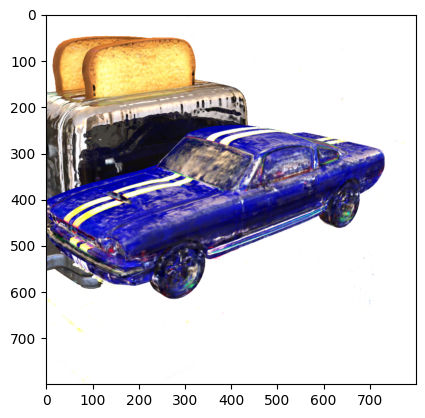

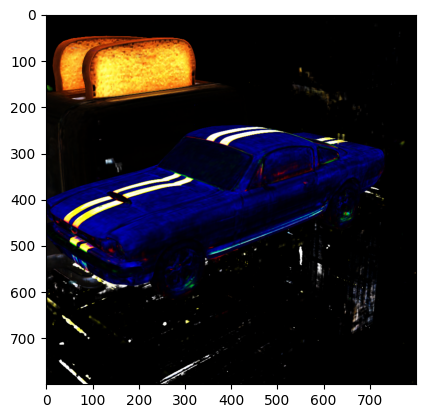

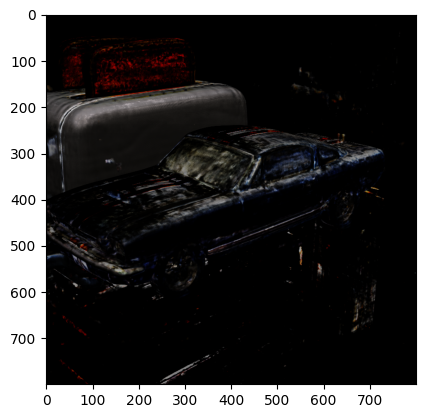

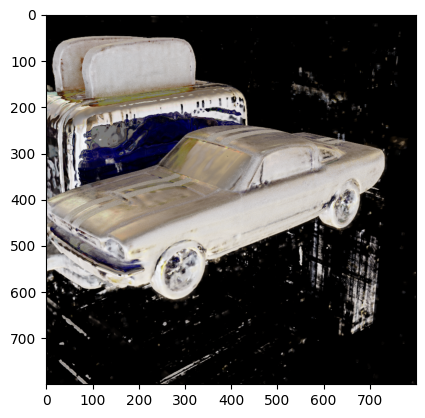

In [ ]:
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['diffuse']*255).numpy().astype(np.uint8))
disp_im((ims['tint']*255).numpy().astype(np.uint8))
disp_im((ims['spec'] / (ims['spec']+1)*255).numpy().astype(np.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


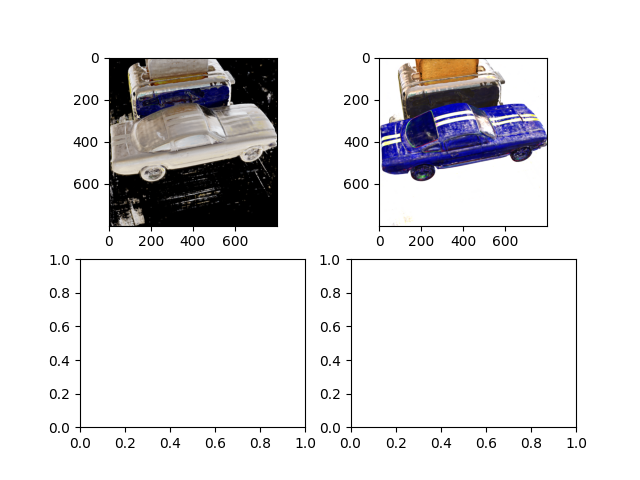

In [ ]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(ims['spec'] / (ims['spec']+1))
ax[0, 1].imshow(ims['rgb_map'])